In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
# Define the transformations to apply to each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

transform

Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

In [3]:
# Load the MNIST training and testing datasets
train_dataset = torchvision.datasets.MNIST(
    root='./data',  # Directory where the data will be stored
    train=True,     # Load the training dataset
    transform=transform,  # Apply the transformations
    download=True   # Download the dataset if not already present
)

train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [4]:
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,    # Load the test dataset
    transform=transform,
    download=True
)

test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [5]:
# Create data loaders for easy batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

print(train_loader)
print(test_loader)

In [6]:
# Verify the dataset shapes
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break  # Show only one batch

Image batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])


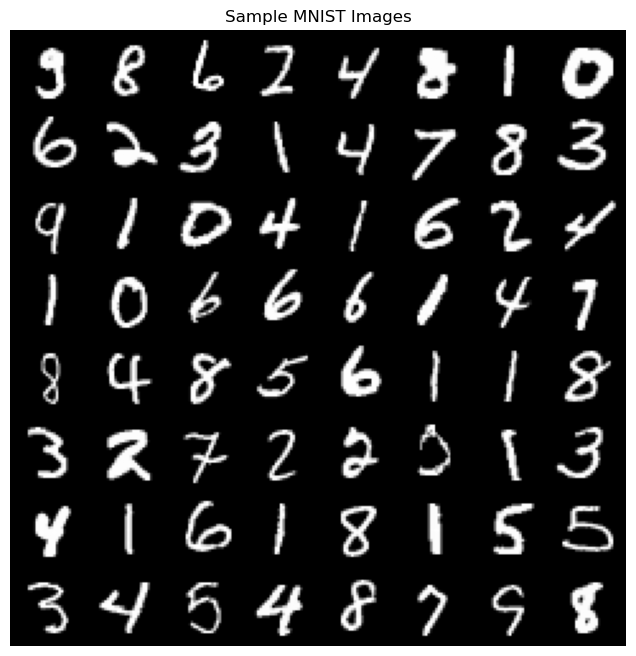

In [7]:
import matplotlib.pyplot as plt
import torchvision

# Function to display a batch of images and their labels
def show_mnist_images(loader):
    # Get one batch of images and labels
    images, labels = next(iter(loader))
    
    # Create a grid of images (8x8) for display
    grid = torchvision.utils.make_grid(images[:64], nrow=8, padding=2, normalize=True)
    
    # Display the images in a grid
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))  # Rearrange dimensions for matplotlib (H x W x C)
    plt.axis('off')
    plt.title("Sample MNIST Images")
    plt.show()

# Display images from the training loader
show_mnist_images(train_loader)


In [12]:
images[1].shape

torch.Size([1, 28, 28])

In [8]:
from collections import Counter

# Extract labels from the dataset
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

# Count occurrences of each label
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Display the counts
print("Training Label Counts:", train_label_counts)
print("Testing Label Counts:", test_label_counts)

Training Label Counts: Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
Testing Label Counts: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [9]:
import torch
import random
from torch.utils.data import Subset
import pickle

In [17]:
import pickle

# Step 1: Extract indices of all samples with label 1
label_1_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 1]

# Step 2: Define the split ratio and split indices for fine-tune and remaining data
fine_tune_ratio = 0.1  # Adjust this ratio as needed
fine_tune_count = int(fine_tune_ratio * len(label_1_indices))

# Shuffle indices for randomness
import random
random.shuffle(label_1_indices)

# Split label 1 indices into fine-tune and remaining sets
fine_tune_indices = label_1_indices[:fine_tune_count]
remaining_indices = label_1_indices[fine_tune_count:] + [i for i, (_, label) in enumerate(train_dataset) if label != 1]

# Step 3: Create separate subsets for fine-tuning and remaining data
fine_tune_data = [train_dataset[i] for i in fine_tune_indices]  # Store actual data
remaining_data = Subset(train_dataset, remaining_indices)

# Step 4: Save fine-tune data to a file
with open('fine_tune_data.pkl', 'wb') as f:
    pickle.dump(fine_tune_data, f)  # Save actual data

# Confirm data separation
print("Fine-tune data saved. Number of samples:", len(fine_tune_data))
print("Remaining data for training. Number of samples:", len(remaining_data))

# Load and verify data
with open('fine_tune_data.pkl', 'rb') as f:
    loaded_fine_tune_data = pickle.load(f)

for i, (image, label) in enumerate(loaded_fine_tune_data):
    print(f"Loaded Sample {i} - Shape: {image.shape}, Label: {label}")
    if i == 4:  # Limit to first few samples
        break


Fine-tune data saved. Number of samples: 674
Remaining data for training. Number of samples: 59326
Loaded Sample 0 - Shape: torch.Size([1, 28, 28]), Label: 1
Loaded Sample 1 - Shape: torch.Size([1, 28, 28]), Label: 1
Loaded Sample 2 - Shape: torch.Size([1, 28, 28]), Label: 1
Loaded Sample 3 - Shape: torch.Size([1, 28, 28]), Label: 1
Loaded Sample 4 - Shape: torch.Size([1, 28, 28]), Label: 1


In [18]:
from torch.utils.data import random_split

# Step 1: Define the ratio for training and testing (80% train, 20% test)
train_size = int(0.8 * len(remaining_data))  # 80% of remaining data for training
test_size = len(remaining_data) - train_size  # 20% for testing

# Step 2: Split the remaining_data into training and testing datasets
train_data, test_data = random_split(remaining_data, [train_size, test_size])

# Step 3: Create DataLoaders for training and testing
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Verify the split
print("Training data size:", len(train_data))
print("Testing data size:", len(test_data))


Training data size: 47460
Testing data size: 11866


### Step 1: Define the Model
First, let's define a simple fully connected neural network (FCNN) for digit classification:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Input layer (MNIST images are 28x28)
        self.fc2 = nn.Linear(128, 64)     # Hidden layer
        self.fc3 = nn.Linear(64, 10)      # Output layer (10 classes for MNIST digits)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))  # ReLU activation for the first layer
        x = torch.relu(self.fc2(x))  # ReLU activation for the second layer
        x = self.fc3(x)  # Output layer
        return x

# Initialize the model
model = SimpleNN()

### Step 2: Define the Loss Function and Optimizer
Now, we will define the loss function and optimizer. Since this is a classification problem, we will use CrossEntropyLoss, and for optimization, we'll use the Adam optimizer:

In [20]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Step 3: Training the Model
Next, let's train the model using the train_loader:

In [21]:
# Set the model to training mode
model.train()

# Training loop
num_epochs = 5  # Adjust the number of epochs based on your requirements

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track the running loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


Epoch [1/5], Loss: 0.4242
Epoch [2/5], Loss: 0.2148
Epoch [3/5], Loss: 0.1542
Epoch [4/5], Loss: 0.1214
Epoch [5/5], Loss: 0.1003


In [22]:
inputs.ndim

4

### Step 4: Evaluate the Model
Once the model is trained, you can evaluate it on the test set:

In [23]:
# Set the model to evaluation mode
model.eval()

# Testing loop
correct = 0
total = 0
with torch.no_grad():  # No need to calculate gradients for testing
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')


Accuracy of the model on the test dataset: 96.33%


In [27]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize variables to track the predictions and true labels
all_predictions = []
all_labels = []

# No gradients needed for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass: Get model predictions
        outputs = model(inputs)
        
        # Get the predicted class by finding the class with the highest score
        _, predicted = torch.max(outputs, 1)
        
        # Store the predictions and true labels for metric calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate Precision, Recall, F1-Score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
cr = classification_report(all_labels, all_predictions)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification report:\n{cr}')


Precision: 0.9639
Recall: 0.9633
F1-Score: 0.9634
Confusion Matrix:
[[1138    0    3    1    3    2    3    2    9    8]
 [   0 1170    4    9    2    0    2    4   13    1]
 [   2    1 1112    4    8    0    2    7   10    2]
 [   3    2   10 1176    0    9    0    8   14    6]
 [   0    1    4    0 1173    0    2    2    2   19]
 [   2    0    8   24    8 1028    5    1   24    8]
 [   1    0    3    0    6    5 1121    1    7    0]
 [   0    0   12    1   12    1    0 1231    5   24]
 [   3    2    1   11    4    1    1    2 1132   10]
 [   1    2    0   10   21    4    0    9   11 1150]]
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1169
           1       0.99      0.97      0.98      1205
           2       0.96      0.97      0.96      1148
           3       0.95      0.96      0.95      1228
           4       0.95      0.98      0.96      1203
           5       0.98      0.93      0.95      1108

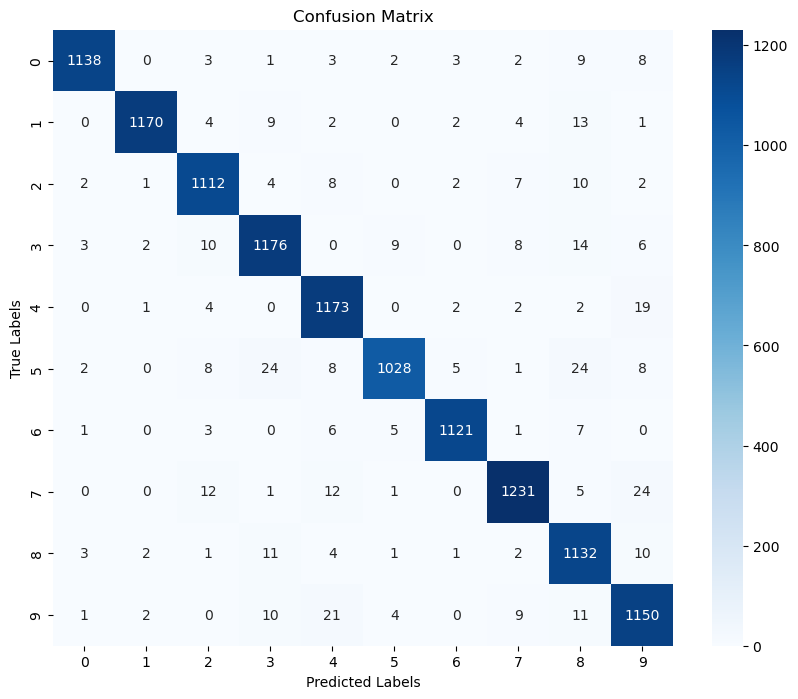

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()


In [29]:
# Save the model
torch.save(model.state_dict(), 'mnist_model.pth')

print("Model saved successfully!")


Model saved successfully!
